# Exploratory Data Analysis of Rotorcraft Data

This notebook is designed to analyze simulated rotorcraft data across multiple CSV files. The analysis will be performed on the entire dataset, which will be aggregated from 20 CSV files. Each maneuver will have a dataset that is taylored to its specifics to get better results, rather than using the same dataset for each maneuver. The final variables were selected with the help of the partners at the FAA.

Additionally, a label column will be added using a predefined label table to facilitate binary classification.


## Import Necessary Libraries and Create Label Table

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from pathlib import Path

# create the label table
label_table = pd.DataFrame({
    'Date': ['2023-06-15', '2023-06-15', '2023-06-15', '2023-06-15', '2023-06-15', '2023-06-15', '2023-06-15', '2023-06-15', '2023-06-15', '2023-06-15', '2023-06-15', '2023-06-15', '2023-06-15', '2023-06-15', '2023-06-15', '2023-06-15', '2023-06-15', '2023-06-15'],
    'StartTime': ['13:22:15.0', '13:25:25.0', '13:29:25.0', '11:56:25.0', '11:58:03.0', '11:59:51.0', '16:10:04.0', '16:11:41.0', '16:14:20.0', '13:43:12.0', '13:44:10.0', '13:45:19.0', '12:08:11.0', '12:09:31.0', '12:10:51.0', '16:34:28.0', '16:35:06.0', '16:38:26.0'],
    'EndTime': ['13:22:25.0', '13:25:38.0', '13:29:40.0', '11:56:38.0', '11:58:24.0', '12:00:00.0', '16:10:12.0', '16:11:46.0', '16:14:29.0', '13:43:35.0', '13:44:18.0', '13:45:30.0', '12:08:35.0', '12:09:52.0', '12:11:18.0', '16:34:42.0', '16:35:27.0', '16:38:36.0'],
    'Label': ['Dynamic Rollover', 'Dynamic Rollover', 'Dynamic Rollover', 'Dynamic Rollover', 'Dynamic Rollover', 'Dynamic Rollover', 'Dynamic Rollover', 'Dynamic Rollover', 'Dynamic Rollover', 'LOW-G', 'LOW-G', 'LOW-G', 'LOW-G', 'LOW-G', 'LOW-G', 'LOW-G', 'LOW-G', 'LOW-G']
})

## Data Preparation

We will pre-process the label table. This step involves converting columns like 'Date', 'StartTime', and 'EndTime' into datetime format to make them machine-readable and facilitate subsequent operations. Extensive research and collaboration with FAA partners led to the selection of features specific to the physics of Dynamic Rollover and Low Gravity. The list below labelled `use_cols_dr` is the columns selected for Dynamic Rollover, and the list labelled `use_cols_lg` is the columns selected for Low-G.

In [2]:
# this is the path to the folder where you have the CSVs, NO OTHER CSVs SHOULD BE PRESENT
# please make sure this path is not inside the scope of GitHub so we do not go over on data for our repo
path = Path('../../CSV')


use_cols_dr = ['Elapsed Time', 'Date', 'System UTC Time', 'Altitude(MSL)', 'Altitude(AGL)', 'Roll Acceleration', 'Pitch Acceleration', 'Yaw Acceleration', 
               'Roll', 'Pitch', 'Yaw', 'Roll Rate', 'Pitch Rate', 'Yaw Rate', 'Groundspeed', 'Wind Speed(True)', 'Sideslip Angle', 'Gross Weight', 'Cyclic Pitch Pos-[0]', 
               'Cyclic Roll Pos-[0]', 'Collective Pos-[0]', 'Pedal Pos', 'Rotor Torque-[0]']

use_cols_lg = ['Elapsed Time', 'Date', 'System UTC Time', 'Altitude(MSL)', 'Altitude(AGL)', 'Airspeed(True)', 'Roll Acceleration', 
               'Pitch Acceleration', 'Yaw Acceleration', 'Roll', 'Pitch', 'Yaw', 'Rotor RPM-[0]', 'Sideslip Angle', 'Vert. Speed', 'Gross Weight','Cyclic Pitch Pos-[0]', 
               'Cyclic Roll Pos-[0]', 'Collective Pos-[0]', 'Pedal Pos', 'Rotor Torque-[0]', 'Wind Speed(True)']
pattern = r'.*2023\.06\.15.*\.csv$'
# convert 'Date', 'StartTime', and 'EndTime' columns to datetime type
label_table['Date'] = pd.to_datetime(label_table['Date'])
label_table['StartTime'] = pd.to_datetime(
    label_table['StartTime'], format='%H:%M:%S.%f').dt.strftime('%H:%M:%S.%f')
label_table['EndTime'] = pd.to_datetime(
    label_table['EndTime'], format='%H:%M:%S.%f').dt.strftime('%H:%M:%S.%f')

## Data Aggregation

Given that our data is spread across multiple CSV files, we need a method to combine them. The `combine_csv_files` function performs the following tasks:
- Lists all CSV files in a given directory.
- Reads each CSV file, drops rows with null values in the 'Elapsed Time' column, and concatenates them into a single DataFrame.
- Applies the labeling based on the label table.
- Filters the dataset based on the given time range.

In [3]:
def combine_csv_files(csv_directory, columns_to_use, label_df):
    # get list of CSV file paths in the directory
    csv_files = [os.path.join(csv_directory, filename) for filename in os.listdir(
        csv_directory) if re.match(pattern, filename)]
    # create an empty dataframe to store the combined data
    combined_df = pd.DataFrame()

    # iterate over each CSV file
    for file in csv_files:
        # read CSV file and select desired columns
        temp_df = pd.read_csv(file, usecols=columns_to_use, names=columns_to_use, skiprows=3, skipfooter=1, engine='python')
        # drop rows that Elapsed Time are mostly null, these are the breaks in simulation
        temp_df.dropna(subset=['Elapsed Time'], inplace=True)
        temp_df.dropna(inplace=True)
        # concatenate the temporary dataframe with the running dataframe
        combined_df = pd.concat([combined_df, temp_df], ignore_index=True)

    # convert the time column on original df to correct format
    combined_df['System UTC Time'] = pd.to_datetime(
    combined_df['System UTC Time'], format='%H:%M:%S.%f').dt.strftime('%H:%M:%S.%f')
    # convert the date column on original df to correct format
    combined_df['Date'] = pd.to_datetime(combined_df['Date'])
    
    # apply the labeling to the dataset
    for _, row in label_df.iterrows():
        # extract date, start time, and end time from the current row
        date = row['Date']
        start_time = row['StartTime']
        end_time = row['EndTime']
        label = row['Label']

        # filter the existing dataset based on matching date and within start time and end time
        filter_condition = (combined_df['Date'] == date) & (
            combined_df['System UTC Time'].between(start_time, end_time))
        combined_df.loc[filter_condition, 'Label'] = label
    dummies_df = pd.get_dummies(combined_df['Label'], dummy_na=False)
    dummies_df = dummies_df.astype(int)
    combined_df = pd.concat([combined_df, dummies_df], axis=1)
    # Convert the time column to pandas datetime format if it's not already in that format
    combined_df['System UTC Time'] = pd.to_datetime(combined_df['System UTC Time'], format='%H:%M:%S.%f')

    # Set the start and end time range
    start_time = pd.to_datetime('11:56:25.0', format='%H:%M:%S.%f')
    end_time = pd.to_datetime('16:38:26.0', format='%H:%M:%S.%f')

    # Filter the DataFrame to include rows between the start and end times
    combined_df = combined_df[(combined_df['System UTC Time'] >= start_time) & (combined_df['System UTC Time'] <= end_time)].copy()

    combined_df.drop(['Elapsed Time', 'Date', 'System UTC Time', 'Label'], inplace=True, axis=1)
    
    return combined_df

In [4]:
# this calls the function from above that cleans and creates dummy variables for our target variables
df_dr = combine_csv_files(path, use_cols_dr, label_table)
df_dr.drop(['LOW-G'], inplace=True, axis=1)

df_lg = combine_csv_files(path, use_cols_lg, label_table)
df_lg.drop(['Dynamic Rollover'], inplace=True, axis=1)

## Data Analysis

Shape, info, and description of dataframe.

In [5]:
df_dr.shape

(258905, 21)

In [6]:
df_dr.info()

<class 'pandas.core.frame.DataFrame'>
Index: 258905 entries, 123586 to 487469
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Altitude(MSL)         258905 non-null  object 
 1   Altitude(AGL)         258905 non-null  float64
 2   Roll Acceleration     258905 non-null  float64
 3   Pitch Acceleration    258905 non-null  float64
 4   Yaw Acceleration      258905 non-null  float64
 5   Roll                  258905 non-null  float64
 6   Pitch                 258905 non-null  float64
 7   Yaw                   258905 non-null  float64
 8   Roll Rate             258905 non-null  float64
 9   Pitch Rate            258905 non-null  float64
 10  Yaw Rate              258905 non-null  float64
 11  Groundspeed           258905 non-null  float64
 12  Wind Speed(True)      258905 non-null  float64
 13  Sideslip Angle        258905 non-null  float64
 14  Gross Weight          258905 non-null  float64
 15  

In [7]:
df_dr['Altitude(MSL)'] = df_dr['Altitude(MSL)'].astype('float')

In [8]:
df_dr.info()

<class 'pandas.core.frame.DataFrame'>
Index: 258905 entries, 123586 to 487469
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Altitude(MSL)         258905 non-null  float64
 1   Altitude(AGL)         258905 non-null  float64
 2   Roll Acceleration     258905 non-null  float64
 3   Pitch Acceleration    258905 non-null  float64
 4   Yaw Acceleration      258905 non-null  float64
 5   Roll                  258905 non-null  float64
 6   Pitch                 258905 non-null  float64
 7   Yaw                   258905 non-null  float64
 8   Roll Rate             258905 non-null  float64
 9   Pitch Rate            258905 non-null  float64
 10  Yaw Rate              258905 non-null  float64
 11  Groundspeed           258905 non-null  float64
 12  Wind Speed(True)      258905 non-null  float64
 13  Sideslip Angle        258905 non-null  float64
 14  Gross Weight          258905 non-null  float64
 15  

In [9]:
df_dr.describe()

,Altitude(MSL),Altitude(AGL),Roll Acceleration,Pitch Acceleration,Yaw Acceleration,Roll,Pitch,Yaw,Roll Rate,Pitch Rate,...,Groundspeed,Wind Speed(True),Sideslip Angle,Gross Weight,Cyclic Pitch Pos-[0],Cyclic Roll Pos-[0],Collective Pos-[0],Pedal Pos,Rotor Torque-[0],Dynamic Rollover
count,258905.000000,258905.000000,258905.000000,258905.000000,258905.000000,258905.000000,258905.000000,258905.000000,258905.000000,258905.000000,...,258905.000000,258905.000000,258905.000000,258905.000000,258905.000000,2.589050e+05,258905.000000,2.589050e+05,258905.000000,258905.000000
mean,39.488460,-86.083724,3819.458922,1618.296703,174.789043,170.092862,-0.382124,0.803859,172.645503,-1.963564,...,78.558985,72.789949,79.740872,8.532586,3814.229063,2.992000e+01,3814.229063,2.992000e+01,1618.313109,0.009868
std,0.127752,14.724336,3543.642437,2061.954307,106.479167,109.630612,6.846074,13.484747,109.877515,17.255726,...,59.723211,55.835317,60.517384,1692.139156,3543.048608,1.421088e-14,3543.048608,1.421088e-14,2061.941428,0.098849
min,39.226385,-105.210944,54.350000,-2.700000,0.000000,0.000000,-73.422000,-179.966000,0.000000,-179.972000,...,0.000000,-24.037000,0.000000,-13390.920000,0.000000,2.992000e+01,0.000000,2.992000e+01,0.000000,0.000000
25%,39.400224,-104.846953,289.440000,0.500000,68.676000,60.801000,-2.091000,-0.333000,62.459000,-3.446000,...,0.942000,0.003000,1.138000,-89.912000,288.992000,2.992000e+01,288.992000,2.992000e+01,0.498000,0.000000
50%,39.464829,-74.660428,2002.560000,1116.440000,188.519000,184.162000,-0.034000,0.259000,190.872000,-0.038000,...,93.555000,90.592000,93.777000,0.000000,2002.333000,2.992000e+01,2002.333000,2.992000e+01,1116.442000,0.000000
75%,39.575691,-74.565914,6391.030000,1996.180000,260.851000,268.490000,2.006000,0.891000,268.577000,1.647000,...,123.386000,118.211000,123.667000,325.947000,6391.014000,2.992000e+01,6391.014000,2.992000e+01,1996.179000,0.000000
max,39.727224,-74.356544,13428.710000,11519.110000,359.976000,359.977000,85.891000,179.781000,360.000000,179.890000,...,220.732000,218.623000,230.833000,7764.597000,13419.375000,2.992000e+01,13419.375000,2.992000e+01,11519.112000,1.000000


In [10]:
df_lg.shape

(258905, 20)

In [11]:
df_lg.info()

<class 'pandas.core.frame.DataFrame'>
Index: 258905 entries, 123586 to 487469
Data columns (total 20 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Altitude(MSL)         258905 non-null  object 
 1   Altitude(AGL)         258905 non-null  float64
 2   Airspeed(True)        258905 non-null  float64
 3   Roll Acceleration     258905 non-null  float64
 4   Pitch Acceleration    258905 non-null  float64
 5   Yaw Acceleration      258905 non-null  float64
 6   Roll                  258905 non-null  float64
 7   Pitch                 258905 non-null  float64
 8   Yaw                   258905 non-null  float64
 9   Rotor RPM-[0]         258905 non-null  float64
 10  Sideslip Angle        258905 non-null  float64
 11  Vert. Speed           258905 non-null  float64
 12  Gross Weight          258905 non-null  float64
 13  Cyclic Pitch Pos-[0]  258905 non-null  float64
 14  Cyclic Roll Pos-[0]   258905 non-null  float64
 15  

In [12]:
df_lg['Altitude(MSL)'] = df_lg['Altitude(MSL)'].astype('float')

In [13]:
df_lg.info()

<class 'pandas.core.frame.DataFrame'>
Index: 258905 entries, 123586 to 487469
Data columns (total 20 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Altitude(MSL)         258905 non-null  float64
 1   Altitude(AGL)         258905 non-null  float64
 2   Airspeed(True)        258905 non-null  float64
 3   Roll Acceleration     258905 non-null  float64
 4   Pitch Acceleration    258905 non-null  float64
 5   Yaw Acceleration      258905 non-null  float64
 6   Roll                  258905 non-null  float64
 7   Pitch                 258905 non-null  float64
 8   Yaw                   258905 non-null  float64
 9   Rotor RPM-[0]         258905 non-null  float64
 10  Sideslip Angle        258905 non-null  float64
 11  Vert. Speed           258905 non-null  float64
 12  Gross Weight          258905 non-null  float64
 13  Cyclic Pitch Pos-[0]  258905 non-null  float64
 14  Cyclic Roll Pos-[0]   258905 non-null  float64
 15  

In [14]:
df_lg.describe()

,Altitude(MSL),Altitude(AGL),Airspeed(True),Roll Acceleration,Pitch Acceleration,Yaw Acceleration,Roll,Pitch,Yaw,Rotor RPM-[0],Sideslip Angle,Vert. Speed,Gross Weight,Cyclic Pitch Pos-[0],Cyclic Roll Pos-[0],Collective Pos-[0],Pedal Pos,Rotor Torque-[0],Wind Speed(True),LOW-G
count,258905.000000,258905.000000,258905.000000,258905.000000,258905.000000,258905.000000,258905.000000,258905.000000,258905.000000,258905.000000,258905.000000,258905.000000,258905.000000,258905.000000,258905.000000,258905.000000,2.589050e+05,258905.000000,2.589050e+05,258905.000000
mean,39.488460,-86.083724,3819.458922,1618.296703,174.789043,170.092862,-0.382124,0.803859,172.645503,-1.963564,-4.216733,78.558985,72.789949,79.740872,8.532586,3814.229063,2.992000e+01,3814.229063,2.992000e+01,0.006651
std,0.127752,14.724336,3543.642437,2061.954307,106.479167,109.630612,6.846074,13.484747,109.877515,17.255726,10.682625,59.723211,55.835317,60.517384,1692.139156,3543.048608,1.421088e-14,3543.048608,1.421088e-14,0.081283
min,39.226385,-105.210944,54.350000,-2.700000,0.000000,0.000000,-73.422000,-179.966000,0.000000,-179.972000,-88.968000,0.000000,-24.037000,0.000000,-13390.920000,0.000000,2.992000e+01,0.000000,2.992000e+01,0.000000
25%,39.400224,-104.846953,289.440000,0.500000,68.676000,60.801000,-2.091000,-0.333000,62.459000,-3.446000,-5.936000,0.942000,0.003000,1.138000,-89.912000,288.992000,2.992000e+01,288.992000,2.992000e+01,0.000000
50%,39.464829,-74.660428,2002.560000,1116.440000,188.519000,184.162000,-0.034000,0.259000,190.872000,-0.038000,-2.209000,93.555000,90.592000,93.777000,0.000000,2002.333000,2.992000e+01,2002.333000,2.992000e+01,0.000000
75%,39.575691,-74.565914,6391.030000,1996.180000,260.851000,268.490000,2.006000,0.891000,268.577000,1.647000,0.000000,123.386000,118.211000,123.667000,325.947000,6391.014000,2.992000e+01,6391.014000,2.992000e+01,0.000000
max,39.727224,-74.356544,13428.710000,11519.110000,359.976000,359.977000,85.891000,179.781000,360.000000,179.890000,78.822000,220.732000,218.623000,230.833000,7764.597000,13419.375000,2.992000e+01,13419.375000,2.992000e+01,1.000000



It's crucial to inspect the balance of classes in a classification problem. Class imbalance can lead to a model that's biased towards predicting the majority class, often leading to poor performance on the minority class.

Let's visualize the distribution of our target variable to better understand the balance of classes. We will see there is data imbalance in both cases.


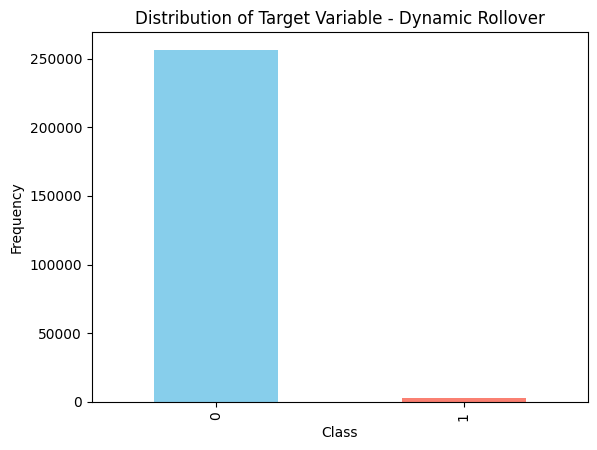

In [15]:
# Plotting the distribution of the target variable
df_dr['Dynamic Rollover'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribution of Target Variable - Dynamic Rollover')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

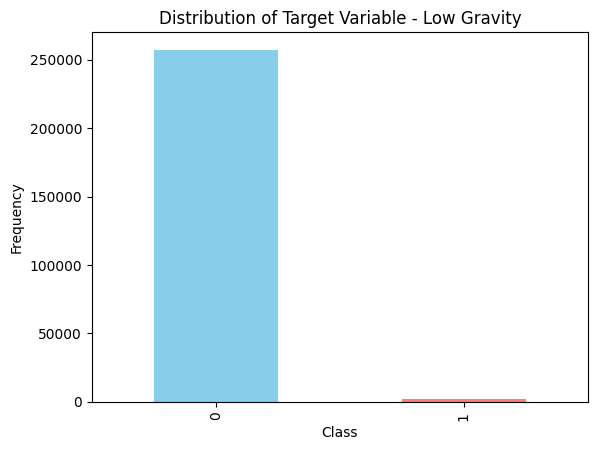

In [16]:
# Plotting the distribution of the target variable
df_lg['LOW-G'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribution of Target Variable - Low Gravity')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

Correlation matrices can be quite insightful when it comes to understanding the relationships between different features in our dataset. A heatmap is a visually appealing method to represent these correlations.

By visualizing correlations:
1. We can identify which features are closely related and might carry redundant information.
2. Potential multicollinearity issues can be spotted. Multicollinearity arises when two or more features are highly correlated, which can make the model unstable.

In [17]:
corr_matrix_dr = df_dr.corr()
corr_matrix_lg = df_lg.corr()

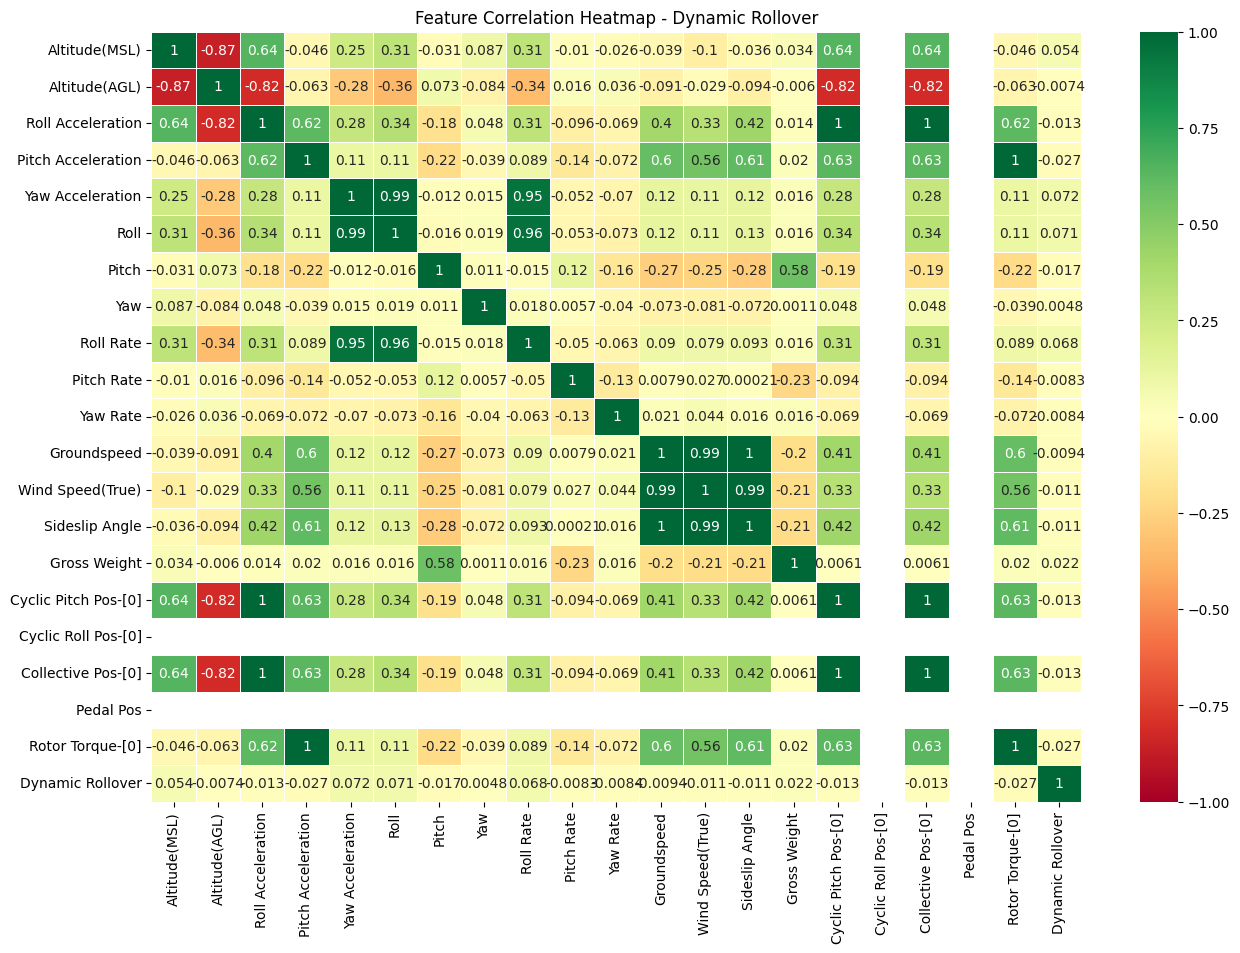

In [18]:
# plotting the heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix_dr,
            annot=True,
            cmap='RdYlGn',
            vmin=-1, vmax=1,
            linewidths=0.5,
            cbar=True)
plt.title('Feature Correlation Heatmap - Dynamic Rollover')
plt.show()

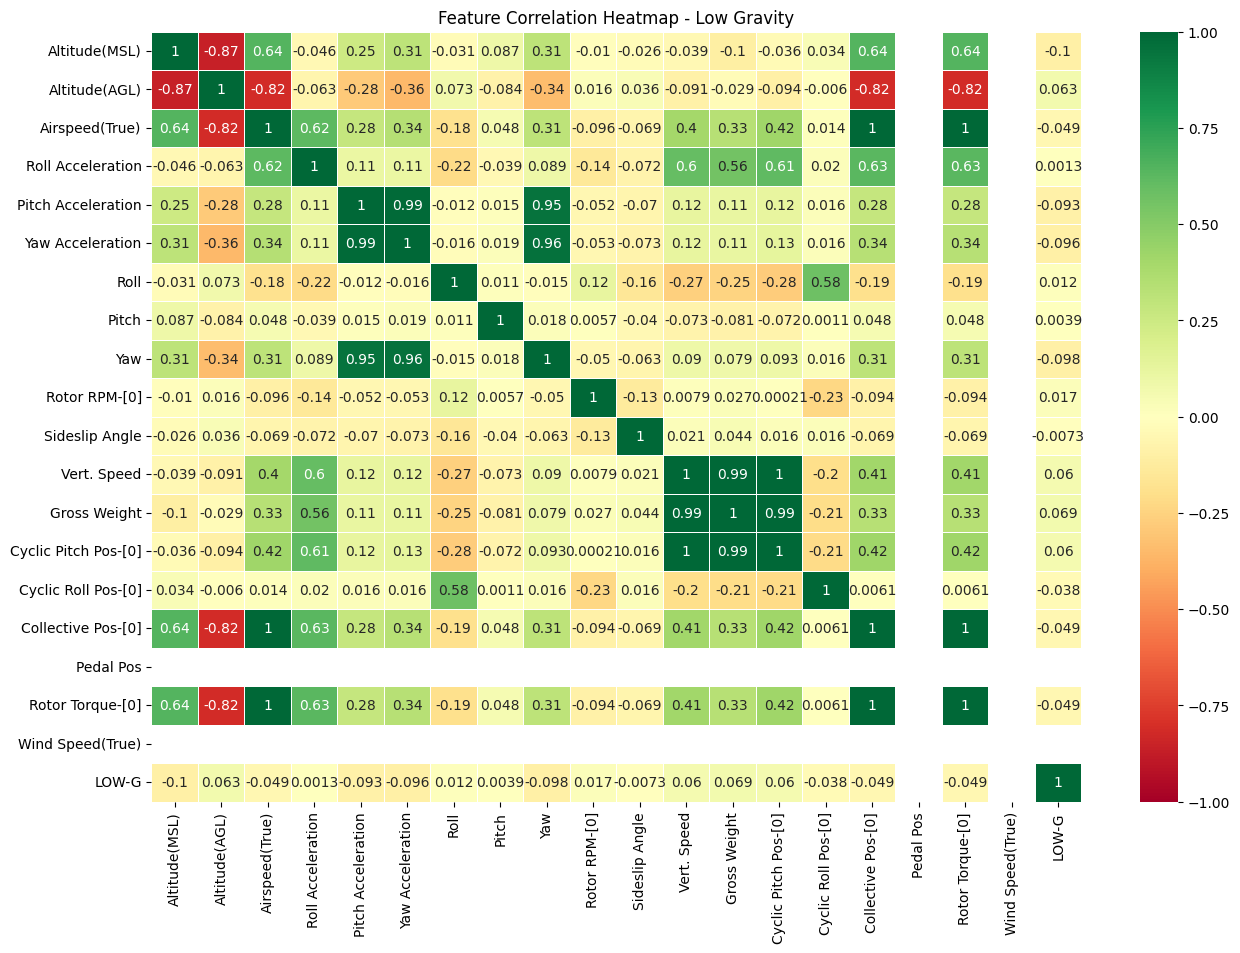

In [19]:
# plotting the heatmap for low-g
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix_lg,
            annot=True,
            cmap='RdYlGn',
            vmin=-1, vmax=1,
            linewidths=0.5,
            cbar=True)
plt.title('Feature Correlation Heatmap - Low Gravity')
plt.show()

## Conclusion

Rows with predominantly null values and columns with very low variance were removed during the feature selection process. The variables left for each maneuver will be used in the modelling phase to classify whether the maneuver is happening during a given instance. The datsets are prepared for modeling. Below are commented out python codeblocks that allow for the datasets to be saved into pickle files (the datasets saved in pickle files should already be available in the data directory).

In [20]:
# with open('../data/dynamic_rollover_pandas_2.0.2.pkl', 'wb') as f:
#     pickle.dump(df_dr, f)

# with open('../data/low_g_pandas_2.0.2.pkl', 'wb') as f:
#     pickle.dump(df_lg, f)